# Infer ***golgi*** - part 6️⃣

--------------

## OBJECTIVE:  ✅ Infer sub-cellular component ***golgi complex***  in order to understand interactome 



Dependencies:
The ***golgi***  inference rely on the **cytosol** mask. 


## IMPORTS

In [2]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict

import numpy as np
import scipy

# TODO:  prune the imports.. this is the big set for almost all organelles
# # function for core algorithm
from scipy import ndimage as ndi
import aicssegmentation
from aicssegmentation.core.seg_dot import dot_3d_wrapper, dot_slice_by_slice, dot_2d_slice_by_slice_wrapper, dot_3d
from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_3d,  
                                                         image_smoothing_gaussian_slice_by_slice )
from aicssegmentation.core.utils import topology_preserving_thinning, size_filter
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.vessel import filament_2d_wrapper, vesselnessSliceBySlice
from aicssegmentation.core.output_utils import   save_segmentation,  generate_segmentation_contour
                                                 
from skimage import filters
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, binary_closing, ball , dilation, remove_small_holes   # function for post-processing (size filter)
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))
from infer_subc_2d.utils.file_io import (read_czi_image, 
                                                                    list_image_files, 
                                                                    export_ome_tiff, 
                                                                    etree_to_dict, 
                                                                    save_parameters, 
                                                                    load_parameters, 
                                                                    export_ndarray)
from infer_subc_2d.utils.img import *
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )        
from infer_subc_2d.organelles.soma import infer_soma
from infer_subc_2d.organelles.nuclei import infer_nuclei
from infer_subc_2d.organelles.cytosol import infer_cytosol

%load_ext autoreload
%autoreload 2

test_img_n = 5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IMAGE PROCESSING Objective 6:  infer ***golgi complex***
> Back to  [OUTLINE: Objective #6](00_pipeline_setup.ipynb#summary-of-objectives)

## summary & steps

Generally following the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

> As per the Allen Cell segmenter sialyltransferase 1 (ST6GAL1) a potential Golgi segmenter. e.g. [Allen Cell](https://www.allencell.org/cell-observations/category/golgi-apparatus).    using [seg_st6gal1.py]("../../../../aics-segmentation/aicssegmentation/structure_wrapper/seg_st6gal1.py") and [playground_st6gal1.ipynb]("../../../../aics-segmentation/lookup_table_demo/playground_st6gal1.ipynb")

### steps 

INPUT
- ch 4
- cytosol mask

PRE-PROCESSING
-   non-local noise reduction
  - size:4, distance:2, cut-off:0.1

CORE-PROCESSING
- adaptive Otsu
    - diameter: (4,100)
  - two classes
    - threshold smoothing scale: 1.34
    - threshold correction factor: .75
    - threshold bounds: (0.14, 1)
    - adaptive window: 20 pixels

  - adaptive Sauvola
    - threshold smoothing scale: 0
    - threshold correction factor: .6
    - threshold bounds: (0. ,1.0)
    - adaptive window: 20 pixels

- POST-PROCESSING
  - N/A

OUTPUT
- inferred  ***golgi*** object


>#### ASIDE: Perform topology-preserving thinning 
>There are two parameters:
>* `thin_dist_preserve`: Half of the minimum width you want to keep from being thinned. For example, when the object width is smaller than 4, you don't want to make this part even thinning (may break the thin object and alter the topology), you can set `thin_dist_preserve` as `2`.
>* `thin_dist`: the amount to thin (has to be an positive integer). The number of pixels to be removed from outter boundary towards center





------------------------
## LOAD RAW IMAGE DATA
Identify path to _raw_ image data and load our example image


In [3]:
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]

img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## CHOOZE Z-SLICE

Lets find the slice with the most overall intensity...

In [4]:
ch_to_agg = ( LYSO_CH ,
                        MITO_CH ,
                        GOLGI_CH ,
                        PEROXI_CH ,
                        ER_CH ,
                        LIPID_CH )
                            
nuc_ch = NUC_CH
optimal_Z = find_optimal_Z(img_data, nuc_ch, ch_to_agg) 



Now get the single "optimal" slice of all our organelle channels....

In [5]:
img_2D = img_data[:,[optimal_Z],:,:].copy()

## Collect the ***cytosol*** mask

i.e. inferred soma, nuclei and cytosol objects
(takes < 1 sec)

In [6]:

soma_mask =  infer_soma(img_2D) 
nuclei_object =  infer_nuclei(img_2D, soma_mask) 
cytosol_mask =  infer_cytosol( nuclei_object,soma_mask) 


## Build  ***Golgi Complex***  specific inference workflow



### INPUT

In [10]:

###################
# INPUT
###################
raw_golgi   = img_2D[GOLGI_CH].copy()



### PRE-PROCESSING

In [12]:
###################
# PRE_PROCESSING
###################


# intensity_norm_param = [0.1, 30.]  # CHECK THIS
# # Linear-ish smoothing
# golgi = intensity_normalization( masked_golgi ,  scaling_param=intensity_norm_param)

golgi = min_max_intensity_normalization( raw_golgi )


med_filter_size = 3  

gaussian_smoothing_sigma = 1.34
gaussian_smoothing_truncate_range = 3.0

struct_img = median_filter_slice_by_slice(golgi,    size=med_filter_size  )

structure_img_smooth = image_smoothing_gaussian_slice_by_slice(   struct_img,
                                                                                                                        sigma=gaussian_smoothing_sigma,
                                                                                                                        truncate_range=gaussian_smoothing_truncate_range,
                                                                                                                    )


struct_img = structure_img_smooth




### CORE PROCESSING

In [17]:
###################
# CORE_PROCESSING
###################
################################
## PARAMETERS for this step ##
cell_wise_min_area = 1200
dot_2d_sigma = 1.6
dot_2d_cutoff = 0.02
thin_dist = 1
thin_dist_preserve = 1.6



###################
# CORE_PROCESSING
###################

bw, object_for_debug = MO(structure_img_smooth, 
                                                global_thresh_method='tri', 
                                                object_minArea=cell_wise_min_area, 
                                                return_object=True)


thin_dist_preserve = 1.6
thin_dist = 1
bw_thin = topology_preserving_thinning(bw, thin_dist_preserve, thin_dist)


################################
## PARAMETERS for this step ##
#s3_param = [[1.6, 0.02]]
s3_param = [(dot_2d_sigma,dot_2d_cutoff)]
################################

bw_extra = dot_3d_wrapper(structure_img_smooth, s3_param)

bw_combine = np.logical_or(bw_extra, bw_thin)


### POST-PROCESSING

In [21]:

###################
# POST_PROCESSING
###################
bw_combine = apply_mask(bw_combine, cytosol_mask)
    
small_object_width = 3

golgi_object = size_filter_2D(bw_combine, 
                                                min_size= small_object_width**2, 
                                                connectivity=1)


#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [20]:
viewer = napari.Viewer()


<Image layer 'bw_thin' at 0x16e331490>

In [22]:

viewer.add_image(
    golgi_object,
    scale=scale
)



<Image layer 'golgi_object [1]' at 0x1794b34f0>

In [ ]:
viewer.scale_bar.visible = True
viewer.add_image(
    bw_extra,
    scale=scale
)
viewer.add_image(
    bw_thin,
    scale=scale
)


### Collect into a single `infer_golgi` function

In [24]:
##########################
#  infer_golgi
##########################
def _infer_golgi(in_img:  np.ndarray, cytosol_mask:  np.ndarray) -> np.ndarray:
    """
    Procedure to infer golgi from linearly unmixed input.

    Parameters:
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels

    cytosol_mask: np.ndarray
        mask of cytosol
 
    Returns:
    -------------
   golgi_object
        mask defined extent of golgi object
    """
   
    ###################
    # PRE_PROCESSING
    ###################     
    struct_img = min_max_intensity_normalization(in_img[GOLGI_CH].copy() )

    med_filter_size = 3   
    struct_img = median_filter_slice_by_slice( 
                                                                    struct_img,
                                                                    size=med_filter_size  )

    gaussian_smoothing_sigma = 1.34
    gaussian_smoothing_truncate_range = 3.0
    struct_img = image_smoothing_gaussian_slice_by_slice(   struct_img,
                                                                                                        sigma=gaussian_smoothing_sigma,
                                                                                                        truncate_range = gaussian_smoothing_truncate_range
                                                                                                    )


   ###################
    # CORE_PROCESSING
    ###################
    cell_wise_min_area = 1200
    bw, object_for_debug = MO(struct_img, 
                                                global_thresh_method='tri', 
                                                object_minArea=cell_wise_min_area, 
                                                return_object=True)


    thin_dist_preserve=1.6
    thin_dist=1
    bw_thin = topology_preserving_thinning(bw, thin_dist_preserve, thin_dist)


    dot_2d_sigma = 1.6
    dot_2d_cutoff = 0.02
    s3_param = [(dot_2d_sigma,dot_2d_cutoff)]

    bw_extra = dot_3d_wrapper(struct_img, s3_param)

    bw = np.logical_or(bw_extra, bw_thin)


    ###################
    # POST_PROCESSING
    ###################
    struct_obj = apply_mask(bw, cytosol_mask)

    small_object_width = 3
    struct_obj = size_filter_2D(struct_obj, 
                                                min_size= small_object_width**2, 
                                                connectivity=1)


    return struct_obj

# TEST  `infer_golgi` function

In [25]:

_golgi_object =  _infer_golgi(img_2D, cytosol_mask) 


In [28]:
from infer_subc_2d.organelles.golgi import infer_golgi 

golgi_object =  infer_golgi(img_2D, cytosol_mask) 


In [29]:

viewer.add_image(
    _golgi_object,
    scale=scale
)
viewer.add_image(
    golgi_object,
    scale=scale
)
viewer.add_labels(
    label(golgi_object),
    scale=scale
)

<Labels layer 'Labels' at 0x18455d2e0>

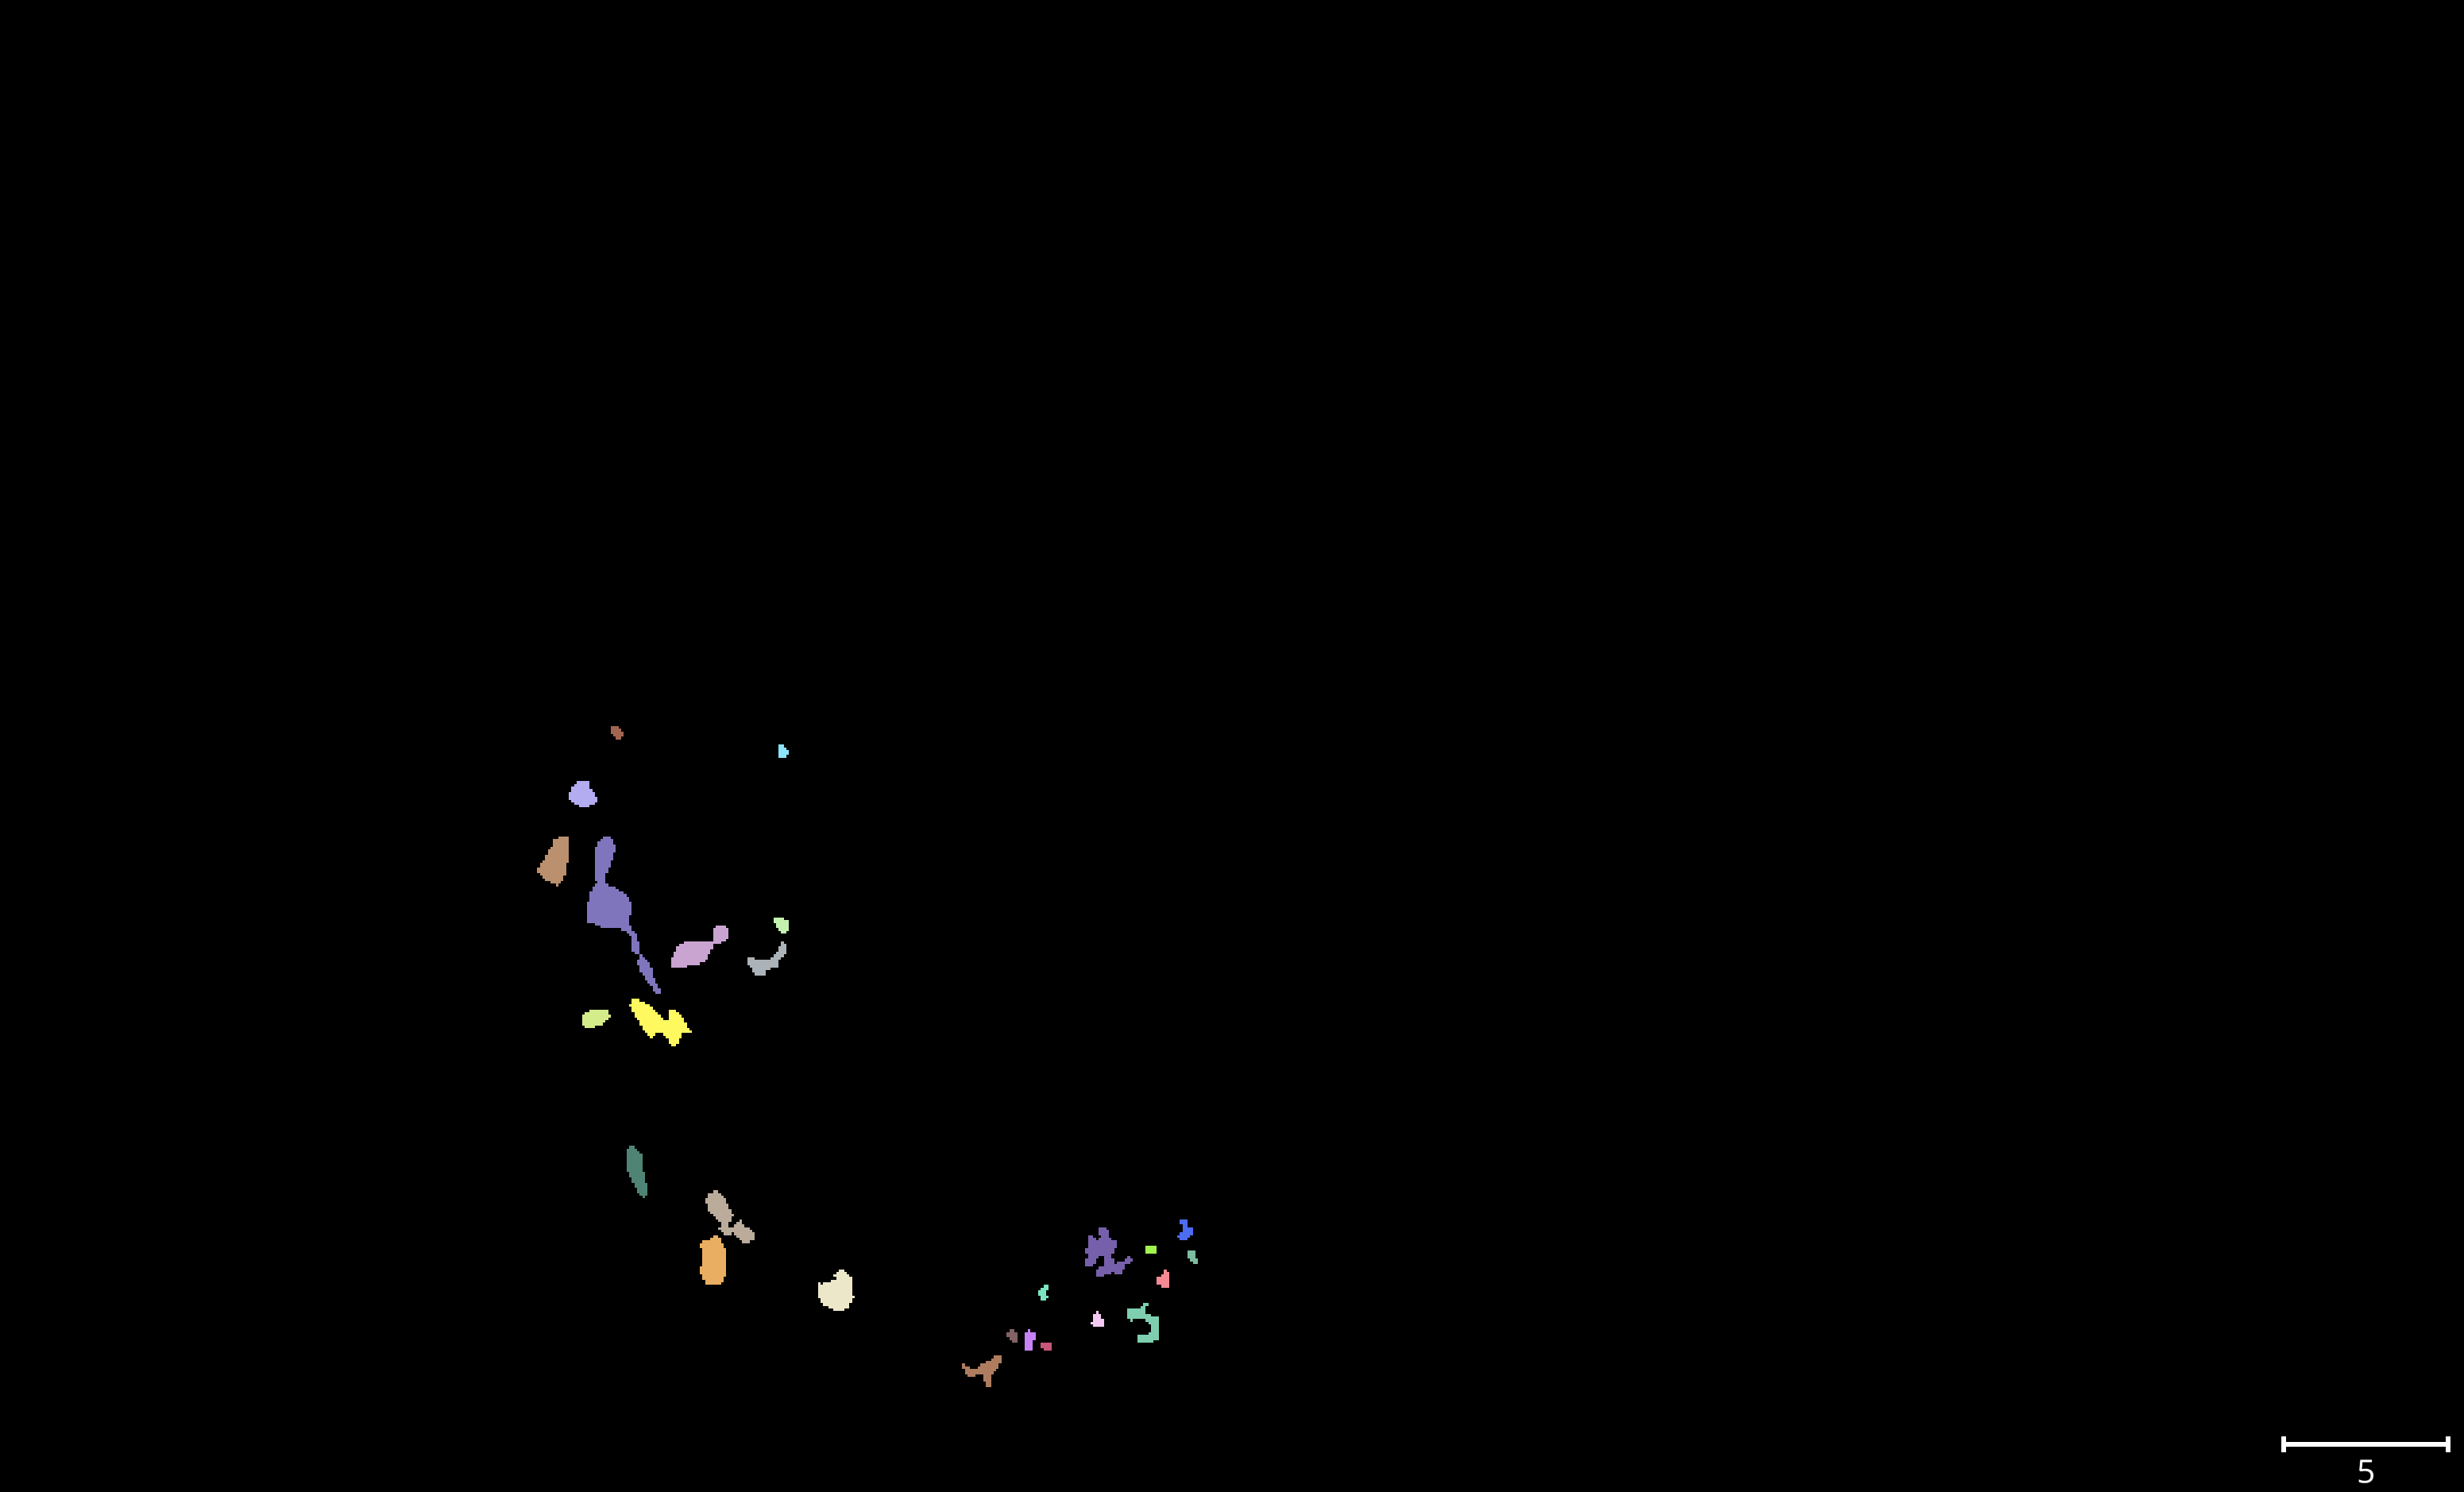

In [30]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)


---------------------

 🚧 WIP 🚧 (🚨🚨🚨🚨 )

 
# WORKFLOW #2 (WIP)
as per 6/22 CellProfiler pipeline from MCZ
 
## summary of steps

INPUT
- ch 4
- CY mask

PRE-PROCESSING
-   non-local noise reduction
  - size:4, distance:2, cut-off:0.08

CORE-PROCESSING
- adaptive Otsu
    - diameter: (4,100)
  - two classes
    - threshold smoothing scale: 1.34
    - threshold correction factor: .75
    - threshold bounds: (0.14, 1)
    - adaptive window: 20 pixels

- POST-PROCESSING
  - N/A

OUTPUT
- object GOLGI 



### INPUT

In [ ]:

###################
# INPUT
###################
struct_img_raw = img_data[3,:,:,:].copy()

# DEFAULT PARAMETERS:
intensity_norm_param = [3.5, 15] # from Allen Cell Segmenter LAMP1  workflow
scaling_param = [0]
gaussian_smoothing_sigma = 1.
gaussian_smoothing_truncate_range = 3.0
dot_2d_sigma = 2
dot_2d_sigma_extra = 1
dot_2d_cutoff = 0.025
min_area = 10
low_level_min_size =  100

med_filter_size =2  

gaussian_smoothing_sigma = 10
gaussian_smoothing_truncate_range = 3.0

aicssegmentation.core.pre_processing_utils.suggest_normalization_param(struct_img_raw) #  [0., 23]


### PRE-PROCESSING

In [ ]:
###################
# PRE_PROCESSING
###################

intensity_norm_param = [0] # 

# Linear-ish smoothing
raw_mito = intensity_normalization( struct_img_raw ,  scaling_param=intensity_norm_param)

med_filter_size =3  

gaussian_smoothing_sigma = 1.3
gaussian_smoothing_truncate_range = 3.0

struct_img = median_filter(raw_mito,    size=med_filter_size  )

structure_img_smooth = image_smoothing_gaussian_3d(   struct_img,
                                                                                                                        sigma=gaussian_smoothing_sigma,
                                                                                                                        truncate_range=gaussian_smoothing_truncate_range,
                                                                                                                    )


# log_img, d = log_transform( structure_img_smooth ) 
# struct_img = intensity_normalization(  log_img  ,  scaling_param=[0] )  

struct_img = structure_img_smooth

### CORE PROCESSING

In [ ]:
###################
# CORE_PROCESSING
###################
def _enhance_speckles(image, radius, volumetric=True):
    radius = radius / 2
    if volumetric:
        selem = ball(radius)
    else:
        selem = disk(radius)     

    # if radius >10:
    #         minimum = scipy.ndimage.minimum_filter(image, footprint=selem)
    #         maximum = scipy.ndimage.maximum_filter(minimum, footprint=selem)
    #         result = data - maximum
    # else:
    result =  white_tophat(image)

    return result

def enhance_neurites(image, radius, volumetric = True):
    if volumetric:
        selem = ball(radius)
    else:
        selem = disk(radius)     
    white = white_tophat(image,selem)
    black = black_tophat(image, selem)
    result = image + white - black
    result[result > 1] = 1
    result[result < 0] = 0

    return result

    



In [ ]:
# enhance spreckles - 40
big_struct_rad = 40
big_img = _enhance_speckles(struct_img.copy(),big_struct_rad, True)



In [ ]:

# enhance spreckles - 10
sm_struct_rad = 20
sm_img = _enhance_speckles(struct_img.copy(),sm_struct_rad, True)


#adaptive_otsu(big_struct) # three class - middle foreground
# adaptive window- 20
#size: 10,100
# threshold smooth 1.34
# threshold correction 1
# threshold (0.1497,1)
#fill holes
# "adatpive" thresholds are NOT currently working... will use      
# "Masked Object Thresholding" - 3D
low_level_min_size = 10
bw_big, _bw_low_level = MO(big_img, 
                                                global_thresh_method='ave', 
                                                object_minArea=low_level_min_size, 
                                                extra_criteria=True,
                                                local_adjust= 0.5, 
                                                return_object=True,
                                                dilate=True)
 # or this?                                               
#    struct_obj = struct_img > filters.threshold_otsu(struct_img)
#     threshold_value_log = threshold_otsu_log(struct_img)

#     threshold_factor = 0.9 #from cellProfiler
#     thresh_min = .1
#     thresh_max = 1.
#     threshold = min( max(threshold_value_log*threshold_factor, thresh_min), thresh_max)
#     struct_obj = struct_img > threshold


# enhance speckles
#   adaptive_sauvola(sm_struct) 
# adaptive window- 10
#size: 2,10
# threshold smooth 1.34
# threshold correction 1
# threshold (0.05,1)
#fill holes
# "adatpive" thresholds are NOT currently working... will use      
# "Masked Object Thresholding" - 3D
low_level_min_size = 2
bw_sm, _bw_low_level = MO(sm_img, 
                                                global_thresh_method='ave', 
                                                object_minArea=low_level_min_size, 
                                                extra_criteria=True,
                                                local_adjust= 0.5, 
                                                return_object=True,
                                                dilate=True)
 # or this?                                               
#    struct_obj = struct_img > filters.threshold_otsu(struct_img)
#     threshold_value_log = threshold_otsu_log(struct_img)
#     threshold_factor = 0.9 #from cellProfiler
#     thresh_min = .1
#     thresh_max = 1.
#     threshold = min( max(threshold_value_log*threshold_factor, thresh_min), thresh_max)
#     struct_obj = struct_img > threshold



### POST-PROCESSING

In [ ]:
###################
# POST_PROCESSING
###################


# 3D
# cleaned_img = remove_small_objects(removed_holes>0, 
#                                                             min_size=minArea, 
#                                                             connectivity=1, 
#                                                             in_place=False)
small_object_width = 10
cleaned_img_big = size_filter(bw_big, # wrapper to remove_small_objects which can do slice by slice
                                                         min_size= small_object_width**2,
                                                         method = "slice_by_slice",
                                                         connectivity=1)


#                                                             in_place=False)
small_object_width = 2
cleaned_img_sm = size_filter(bw_sm, # wrapper to remove_small_objects which can do slice by slice
                                                         min_size= small_object_width**2,
                                                         method = "slice_by_slice",
                                                         connectivity=1)



cleaned_img = np.logical_or(cleaned_img_big, cleaned_img_sm)



#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [ ]:

if viewer is None:
    viewer = napari.view_image(
        cleaned_img,
        scale=scale
    )
else: 
    viewer.add_image(
        cleaned_img,
        scale=scale
    )

viewer.scale_bar.visible = True
viewer.add_image(
    cleaned_img_big,
    scale=scale
)

viewer.add_image(
    big_img,
    scale=scale
)
viewer.add_image(
    cleaned_img_big,
    scale=scale
)
viewer.add_image(
    sm_img,
    scale=scale
)